# 1. Imports 

In [3]:
import pandas as pd
import sklearn.model_selection
import sklearn.metrics
from autogluon.multimodal import MultiModalPredictor
from autogluon.tabular import TabularPredictor
import warnings
import time
import pickle
warnings.filterwarnings('ignore')

/root/anaconda3/envs/ag/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
import plotly.express as px
import plotly.io as pio
from plotly.subplots import make_subplots
pd.options.plotting.backend = "plotly"
pio.templates.default = "plotly_white"

In [5]:
def remove_emoji(inputString):
    return inputString.encode('ascii', 'ignore').decode('ascii')

In [6]:
def generate_experiment2(train_size,test_size,added_n,experiments_index):
    #---# A: 리얼데이터만 추가
    df_train = pd.concat([
        df_kaggle[df_kaggle['type'] != 'ENFJ'][::2],
        df_kaggle[df_kaggle['type'] == 'ENFJ'][:train_size],
        df_kaggle[df_kaggle['type'] == 'ENFJ'][train_size:(train_size+added_n)],
    ]).reset_index(drop=True)
    df_test = pd.concat([
        df_kaggle[df_kaggle['type'] == 'ENFJ'][-test_size:],
        df_kaggle[df_kaggle['type'] != 'ENFJ'][1::2]
    ])
    df_trains_dct[f'{experiments_index}a'] = df_train 
    df_tests_dct[f'{experiments_index}a'] = df_test
    _df1 = df_train[:-added_n]['type'].value_counts().reset_index().assign(Source='Kaggle')
    _df2 = df_train[-added_n:]['type'].value_counts().reset_index().assign(Source='Kaggle')
    _train = pd.concat([_df1,_df2],axis=0).reset_index(drop=True).assign(DataType = 'Train')
    _test = df_test['type'].value_counts().reset_index().assign(DataType = 'Test',Source='Kaggle')
    tidydata1= pd.concat([_train,_test]).reset_index(drop=True).assign(col = lambda df: df.Source.map({'Kaggle':0,'ChatGPT':1})).query('type == "ENFJ"')
    #---# B: GPT 자료만 추가 
    df_train = pd.concat([
        df_kaggle[df_kaggle['type'] != 'ENFJ'][::2],
        df_kaggle[df_kaggle['type'] == 'ENFJ'][:train_size],
        df_gpt_ENFJ[df_gpt_ENFJ['type'] == 'ENFJ'][:added_n],
    ]).reset_index(drop=True)
    df_test = pd.concat([
        df_kaggle[df_kaggle['type'] == 'ENFJ'][-test_size:],
        df_kaggle[df_kaggle['type'] != 'ENFJ'][1::2]
    ])
    df_trains_dct[f'{experiments_index}b'] = df_train 
    df_tests_dct[f'{experiments_index}b'] = df_test
    _df1 = df_train[:-added_n]['type'].value_counts().reset_index().assign(Source='Kaggle')
    _df2 = df_train[-added_n:]['type'].value_counts().reset_index().assign(Source='ChatGPT')
    _train = pd.concat([_df1,_df2],axis=0).reset_index(drop=True).assign(DataType = 'Train')
    _test = df_test['type'].value_counts().reset_index().assign(DataType = 'Test',Source='Kaggle')
    tidydata2 = pd.concat([_train,_test]).reset_index(drop=True).assign(col = lambda df: df.Source.map({'Kaggle':0,'ChatGPT':1})).query('type=="ENFJ"')
    #---# C: Real+GPT 동시추가 
    df_train = pd.concat([
        df_kaggle[df_kaggle['type'] != 'ENFJ'][::2],        
        df_kaggle[df_kaggle['type'] == 'ENFJ'][:train_size],
        df_gpt_ENFJ[df_gpt_ENFJ['type'] == 'ENFJ'][:added_n],
        df_kaggle[df_kaggle['type'] == 'ENFJ'][train_size:(train_size+added_n)],
    ]).reset_index(drop=True)
    df_test = pd.concat([
        df_kaggle[df_kaggle['type'] == 'ENFJ'][-test_size:],
        df_kaggle[df_kaggle['type'] != 'ENFJ'][1::2]
    ])
    df_trains_dct[f'{experiments_index}c'] = df_train 
    df_tests_dct[f'{experiments_index}c'] = df_test
    _df1 = df_train[:-added_n]['type'].value_counts().reset_index().assign(Source='Kaggle')
    _df2 = df_train[-added_n:]['type'].value_counts().reset_index().assign(Source='ChatGPT')
    _train = pd.concat([_df1,_df2],axis=0).reset_index(drop=True).assign(DataType = 'Train')
    _test = df_test['type'].value_counts().reset_index().assign(DataType = 'Test',Source='Kaggle')
    tidydata3 = pd.concat([_train,_test]).reset_index(drop=True).assign(col = lambda df: df.Source.map({'Kaggle':0,'ChatGPT':1})).query('type=="ENFJ"')
    #---#
    tidydata = pd.concat([tidydata1.assign(Setting = 'Real'),tidydata2.assign(Setting = 'Synthetic'),tidydata2.assign(Setting = 'Real+Synthetic')])
    tidydata.to_csv(f"정리된자료(csv)/tidydata_{experiments_index.replace('/','')}.csv",index=False)    

In [55]:
def generate_experiment3(train_size,test_size,added_n,experiments_index):
    #---# A: 리얼데이터만 추가
    df_train = pd.concat([
        df_kaggle.query('type in ["ISTP","ESTP","INTP","ISFP","ISTJ"]')[::2],
        df_kaggle[df_kaggle['type'] == 'ENFJ'][:train_size],
        df_kaggle[df_kaggle['type'] == 'ENFJ'][train_size:(train_size+added_n)],
    ]).reset_index(drop=True)
    df_test = pd.concat([
        df_kaggle.query('type in ["ISTP","ESTP","INTP","ISFP","ISTJ"]')[::2],
        df_kaggle[df_kaggle['type'] == 'ENFJ'][-test_size:],        
    ])
    df_trains_dct[f'{experiments_index}a'] = df_train 
    df_tests_dct[f'{experiments_index}a'] = df_test
    _df1 = df_train[:-added_n]['type'].value_counts().reset_index().assign(Source='Kaggle')
    _df2 = df_train[-added_n:]['type'].value_counts().reset_index().assign(Source='Kaggle')
    _train = pd.concat([_df1,_df2],axis=0).reset_index(drop=True).assign(DataType = 'Train')
    _test = df_test['type'].value_counts().reset_index().assign(DataType = 'Test',Source='Kaggle')
    tidydata1= pd.concat([_train,_test]).reset_index(drop=True).assign(col = lambda df: df.Source.map({'Kaggle':0,'ChatGPT':1}))
    #---# B: GPT 자료만 추가 
    df_train = pd.concat([
        df_kaggle.query('type in ["ISTP","ESTP","INTP","ISFP","ISTJ"]')[::2],
        df_kaggle[df_kaggle['type'] == 'ENFJ'][:train_size],
        df_gpt[df_gpt['type'] == 'ENFJ'][:added_n],
    ]).reset_index(drop=True)
    df_test = pd.concat([
        df_kaggle[df_kaggle['type'] == 'ENFJ'][-test_size:],
        df_kaggle.query('type in ["ISTP","ESTP","INTP","ISFP","ISTJ"]')[::2],
    ])
    df_trains_dct[f'{experiments_index}b'] = df_train 
    df_tests_dct[f'{experiments_index}b'] = df_test
    _df1 = df_train[:-added_n]['type'].value_counts().reset_index().assign(Source='Kaggle')
    _df2 = df_train[-added_n:]['type'].value_counts().reset_index().assign(Source='ChatGPT')
    _train = pd.concat([_df1,_df2],axis=0).reset_index(drop=True).assign(DataType = 'Train')
    _test = df_test['type'].value_counts().reset_index().assign(DataType = 'Test',Source='Kaggle')
    tidydata2 = pd.concat([_train,_test]).reset_index(drop=True).assign(col = lambda df: df.Source.map({'Kaggle':0,'ChatGPT':1}))
    tidydata = pd.concat([tidydata1.assign(Setting = 'Real'),tidydata2.assign(Setting = 'Synthetic')])
    tidydata.to_csv(f"정리된자료(csv)/tidydata_{experiments_index.replace('/','')}.csv",index=False)    

# 2. Data

`-` 데이터의 정리 

In [56]:
labels = ['ENTP', 'ESFP', 'ISFJ', 'INTJ', 'ISFP', 'ESTP', 'INTP', 'INFJ', 'ESTJ', 'ENFP', 'ISTJ', 'ENTJ', 'INFP', 'ISTP', 'ESFJ', 'ENFJ']
df_kaggle = pd.read_csv('원래자료(csv)/mbti_1.csv').sort_values('type').reset_index(drop=True)
df_gpt = pd.read_csv('원래자료(csv)/MBTI.csv')
for i,post in enumerate(df_gpt['posts']):
    for label in labels:
        if label in post: 
            df_gpt['posts'][i] = post.replace(label,'')
            df_gpt['posts'][i] = remove_emoji(post)
df_gpt = df_gpt.set_index('type').rename(
    {
        'ESFJ ':'ESFJ',
        'ESFP ': 'ESFP',
        'ESTJ ': 'ESTJ',
        'ESTP"': 'ESTP',
        'estp': 'ESTP'
    }
).reset_index().sort_values('type').reset_index(drop=True)

- `df`는 원래 캐글에 공개된 자료
- `df_additional`은 chatGPT를 이용하여 모은자료, 이중 자료로서의 가치가 없는 관측치는 제외함. (자료가 너무 적어서 제외하였음 {SFJ:2, ISFJ:32, ENFP:1})

In [57]:
!rm -rf '정리된자료(csv)'
![ -d "정리된자료(csv)" ] || mkdir "정리된자료(csv)"
df_kaggle.to_csv("정리된자료(csv)/df_kaggle.csv",index=False)
df_gpt.to_csv("정리된자료(csv)/df_gpt.csv",index=False)

In [58]:
df_kaggle = pd.read_csv("정리된자료(csv)/df_kaggle.csv")
df_gpt = pd.read_csv("정리된자료(csv)/df_gpt.csv")

`-` 데이터의 분포상태 

In [59]:
df_kaggle['type'].value_counts()

type
INFP    1832
INFJ    1470
INTP    1304
INTJ    1091
ENTP     685
ENFP     675
ISTP     337
ISFP     271
ENTJ     231
ISTJ     205
ENFJ     190
ISFJ     166
ESTP      89
ESFP      48
ESFJ      42
ESTJ      39
Name: count, dtype: int64

In [60]:
df_kaggle['type'].value_counts()

type
INFP    1832
INFJ    1470
INTP    1304
INTJ    1091
ENTP     685
ENFP     675
ISTP     337
ISFP     271
ENTJ     231
ISTJ     205
ENFJ     190
ISFJ     166
ESTP      89
ESFP      48
ESFJ      42
ESTJ      39
Name: count, dtype: int64

`-` 데이터의 분포상태 시각화 

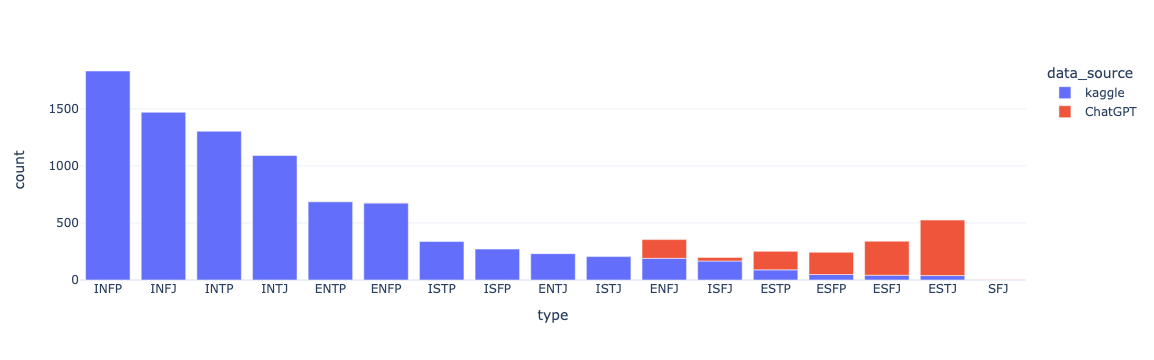

In [61]:
_df1 = df_kaggle['type'].value_counts().to_frame().reset_index().assign(data_source = 'kaggle')
_df2 = df_gpt['type'].value_counts().reset_index().assign(data_source = 'ChatGPT')
tidydata = pd.concat([_df1,_df2]).reset_index(drop=True)
px.bar(
    tidydata,
    x='type',
    y='count',
    color='data_source',
)

`-` 조사 

**원래자료** 

In [62]:
{'ESTP':162+89,'ESFP':195+48,'ESFJ':298+42,'ESTJ':486+39}

{'ESTP': 251, 'ESFP': 243, 'ESFJ': 340, 'ESTJ': 525}

**총 숫자를 맞춘다면** 

In [63]:
{'ESTP':151+89,'ESFP':192+48,'ESFJ':198+42,'ESTJ':201+39}

{'ESTP': 240, 'ESFP': 240, 'ESFJ': 240, 'ESTJ': 240}

**train data의 숫자를 맞춘다면**

In [64]:
{'ESTP':155+45,'ESFP':176+24,'ESFJ':179+21,'ESTJ':181+19}

{'ESTP': 200, 'ESFP': 200, 'ESFJ': 200, 'ESTJ': 200}

`-` df_gpt를 나누자.. 

In [65]:
df_gpt_ENFJ = df_gpt[df_gpt['type'] == 'ENFJ'][:160] 
#---#
df_gpt_ESTP = df_gpt[df_gpt['type'] == 'ESTP'][:155]
df_gpt_ESFP = df_gpt[df_gpt['type'] == 'ESFP'][:176]
df_gpt_ESFJ = df_gpt[df_gpt['type'] == 'ESFJ'][:179]
df_gpt_ESTJ = df_gpt[df_gpt['type'] == 'ESTJ'][:181]

In [66]:
df_trains_dct = dict()
df_tests_dct = dict()

# 3. 실험1 -- 셋팅

**시나리오1**

In [67]:
df_train = df_kaggle[::2].reset_index(drop=True)
df_test = df_kaggle[1::2].reset_index(drop=True)
df_trains_dct['실험1/시나리오1'] = df_train 
df_tests_dct['실험1/시나리오1'] = df_test 
#---#
_train = df_train['type'].value_counts().reset_index().assign(DataType = 'Train')
_test = df_test['type'].value_counts().reset_index().assign(DataType = 'Test')
tidydata = pd.concat([_train,_test]).reset_index(drop=True)
tidydata.to_csv("정리된자료(csv)/tidydata_실험1시나리오1.csv",index=False)

**시나리오2**

In [68]:
df_train = pd.concat([
    df_kaggle[::2],
    df_gpt_ESTP,
    df_gpt_ESFP,
    df_gpt_ESFJ,
    df_gpt_ESTJ,
]).reset_index(drop=True)
df_test = df_kaggle[1::2].reset_index(drop=True)
df_trains_dct['실험1/시나리오2'] = df_train 
df_tests_dct['실험1/시나리오2'] = df_test 
#---#
n = len(df_kaggle[::2])
_df1 = df_train[:n]['type'].value_counts().reset_index().assign(Source='Kaggle')
_df2 = df_train[n:]['type'].value_counts().reset_index().assign(Source='ChatGpt')
_train = pd.concat([_df1,_df2],axis=0).reset_index(drop=True).assign(DataType = 'Train')
_test = df_test['type'].value_counts().reset_index().assign(DataType = 'Test',Source='Kaggle')
tidydata = pd.concat([_train,_test]).reset_index(drop=True).assign(col = lambda df: df.Source.map({'Kaggle':0,'ChatGPT':1}))
tidydata.to_csv("정리된자료(csv)/tidydata_실험1시나리오2.csv",index=False)

# 4. 실험2 -- 셋팅

In [69]:
print(f"df_kaggle에는 ENFJ가 {(df_kaggle['type'] == 'ENFJ').sum()}명 있음")
print(f"df_gpt에는 ENFJ가 {(df_gpt['type'] == 'ENFJ').sum()}명 있음")

df_kaggle에는 ENFJ가 190명 있음
df_gpt에는 ENFJ가 164명 있음


In [70]:
generate_experiment2(train_size=1,test_size=30,added_n=0,experiments_index='실험2/시나리오0')
generate_experiment2(train_size=1,test_size=30,added_n=40,experiments_index='실험2/시나리오1')
generate_experiment2(train_size=1,test_size=30,added_n=80,experiments_index='실험2/시나리오2')
generate_experiment2(train_size=1,test_size=30,added_n=120,experiments_index='실험2/시나리오3')
generate_experiment2(train_size=1,test_size=30,added_n=159,experiments_index='실험2/시나리오4')

# 5. 실험3 -- 셋팅

In [87]:
print(f"df_kaggle에는 ENFJ가 {(df_kaggle['type'] == 'ENFJ').sum()}명 있음")
print(f"df_gpt에는 ENFJ가 {(df_gpt['type'] == 'ENFJ').sum()}명 있음")

df_kaggle에는 ENFJ가 190명 있음
df_gpt에는 ENFJ가 164명 있음


In [88]:
generate_experiment3(train_size=1,test_size=40,added_n=0,experiments_index='실험3/시나리오0')
generate_experiment3(train_size=1,test_size=40,added_n=20,experiments_index='실험3/시나리오1')
generate_experiment3(train_size=1,test_size=40,added_n=40,experiments_index='실험3/시나리오2')
generate_experiment3(train_size=1,test_size=40,added_n=60,experiments_index='실험3/시나리오3')
generate_experiment3(train_size=1,test_size=40,added_n=80,experiments_index='실험3/시나리오4')
generate_experiment3(train_size=1,test_size=40,added_n=100,experiments_index='실험3/시나리오5')
generate_experiment3(train_size=1,test_size=40,added_n=120,experiments_index='실험3/시나리오6')
generate_experiment3(train_size=1,test_size=40,added_n=140,experiments_index='실험3/시나리오7')

In [92]:
df_trains_dct['실험3/시나리오1a']['type'].value_counts()

type
INTP    652
ISTP    168
ISFP    135
ISTJ    103
ESTP     45
ENFJ     21
Name: count, dtype: int64

# 4. 실험셋팅 저장 

In [73]:
df_trains_dct.keys()

dict_keys(['실험1/시나리오1', '실험1/시나리오2', '실험2/시나리오0a', '실험2/시나리오0b', '실험2/시나리오0c', '실험2/시나리오1a', '실험2/시나리오1b', '실험2/시나리오1c', '실험2/시나리오2a', '실험2/시나리오2b', '실험2/시나리오2c', '실험2/시나리오3a', '실험2/시나리오3b', '실험2/시나리오3c', '실험2/시나리오4a', '실험2/시나리오4b', '실험2/시나리오4c', '실험3/시나리오0a', '실험3/시나리오0b', '실험3/시나리오1a', '실험3/시나리오1b', '실험3/시나리오2a', '실험3/시나리오2b', '실험3/시나리오3a', '실험3/시나리오3b', '실험3/시나리오4a', '실험3/시나리오4b', '실험3/시나리오5a', '실험3/시나리오5b', '실험3/시나리오6a', '실험3/시나리오6b', '실험3/시나리오7a', '실험3/시나리오7b'])

In [74]:
!rm -rf 실험셋업
![ -d "실험셋업" ] || mkdir "실험셋업"
with open(file='실험셋업/df_trains_dct.pickle', mode='wb') as f:
    pickle.dump(obj=df_trains_dct,file=f)    
with open(file='실험셋업/df_tests_dct.pickle', mode='wb') as f:
    pickle.dump(obj=df_tests_dct,file=f)        